In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Fit a mesh and cameras simultaneously

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file.
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=37694219b6590dc6469222f52c523d5814a23898e0c80654e1af2e397b2611a6
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Trying to install wheel for PyTorch3D
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt241/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 221.9 MB/s eta 0:00:00


In [2]:
import os
import torch
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/camera_visualization.py
from camera_visualization import plot_camera_scene
# install this package for output plotly
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -U kaleido

--2024-10-20 01:05:05--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-10-20 01:05:05 (43.9 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]

--2024-10-20 01:05:05--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/camera_visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

OR if running **locally** uncomment and run the following cell:

In [ ]:
#  from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object.

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes.

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes.

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path.

In [4]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2024-10-20 01:06:57--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.15, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.01s   

2024-10-20 01:06:57 (28.7 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2024-10-20 01:06:57--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.15, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl     

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
# to its original center and scale.  Note that normalizing the target mesh,
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((1.0 / float(scale)));

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.
For simplicity, all cameras point towards the mesh

```
# This is formatted as code
```




In [6]:
# Number of different viewpoints
num_views = 8

# Image size
img_size = 128

# Construct viewing angles from 8-vertex platonic solid, which is a cube
# Vertices of a cube in Cartesian coordinates
vertices = torch.tensor([
    [ 1,  1,  1],
    [ 1,  1, -1],
    [ 1, -1,  1],
    [ 1, -1, -1],
    [-1,  1,  1],
    [-1,  1, -1],
    [-1, -1,  1],
    [-1, -1, -1]
], dtype=torch.float32)

# Calculate the radial distance (r) for normalization
r = torch.norm(vertices, dim=1)

# Calculate elevation (theta)
elev = torch.atan2(vertices[:, 2], torch.norm(vertices[:, :2], dim=1))

# Calculate azimuth (phi)
azim = torch.atan2(vertices[:, 1], vertices[:, 0])

# Point light
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize cameras
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim, degrees=False)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
view_idx = 6
camera = FoVPerspectiveCameras(device=device, R=R[None, view_idx, ...], T=T[None, view_idx, ...])


# Rasterization and shading settings for standard renderer
# Here we set the output image to be of size
# img_size x img_size. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
# the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=img_size,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Rasterization and shading settings for silhouette renderer
raster_settings_silhouette = RasterizationSettings(
    image_size=img_size,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Create standard renderer for creating ground truth rgb images
renderer_std = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

# Create Silhouette renderer for creating ground truth silhouette images
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)


# Create target images

meshes = mesh.extend(num_views)
gt_rgb = renderer_std(meshes, cameras=cameras, lights=lights)
# Render silhouette images.  The 3rd channel of the rendering output is
# the alpha/silhouette channel
gt_silhouette = renderer_silhouette(meshes, cameras=cameras, lights=lights)
gt_camera_pts = cameras.get_camera_center()

Visualize the dataset:

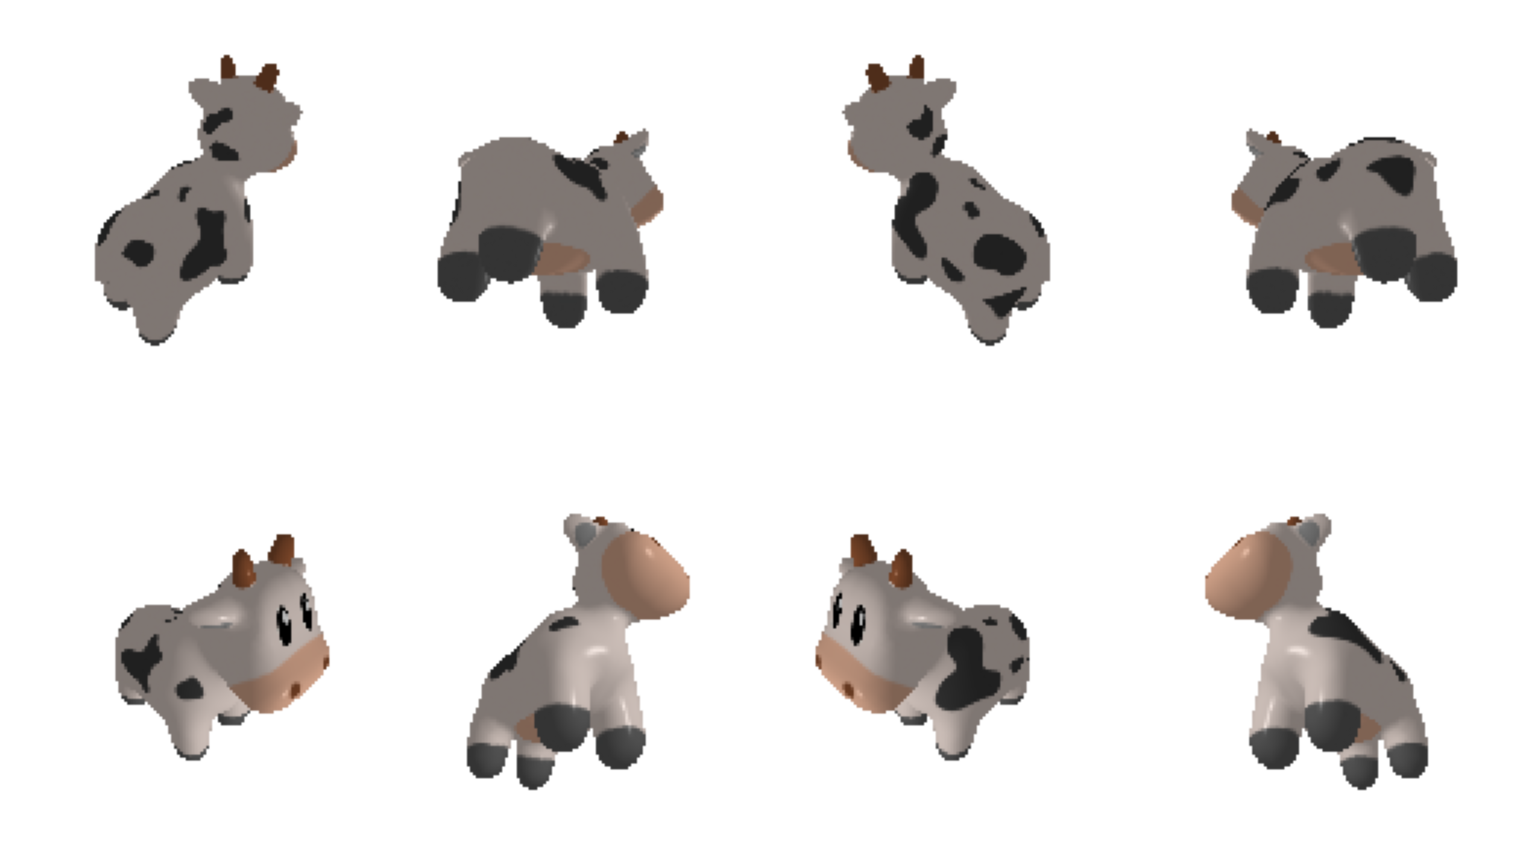

In [7]:
# RGB images
image_grid(gt_rgb.cpu().numpy(), rows=2, cols=4, rgb=True)
plt.show()

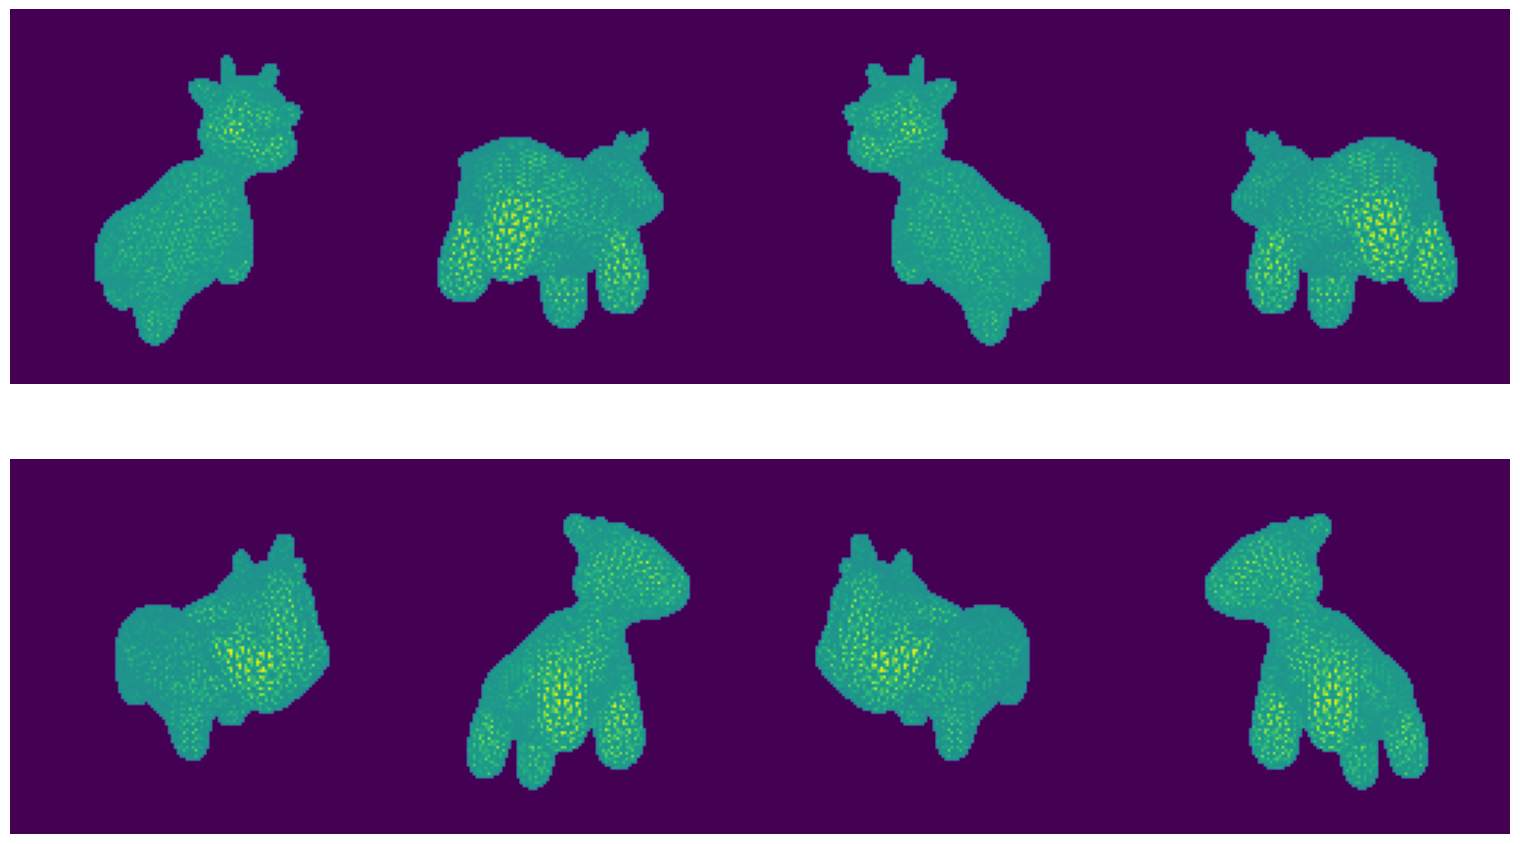

In [8]:
# Visualize silhouette images
image_grid(gt_silhouette.cpu().numpy(), rows=2, cols=4, rgb=False)
plt.show()

## 3. Mesh and camera prediction via differentiable rendering

In the previous section, we created a dataset of multi-view rgb images and silhouette images of a cow. In this section, we will restore the cow mesh as well as camera positions without any knowledge of the ground truth cow mesh or the original camera positions. This is done through inverse rendering. We assume camera positions are perturbed locally so that the ordering of rendered views align with ground truth, and also the light source is known.

We first create a differentiable textured renderer. Here we apply a sigma so that we ensure differentiablity at edges.

In [9]:
# Rasterization settings for differentiable rendering
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=img_size,
    blur_radius=np.log(1. / 1e-4 - 1.) * sigma,
    faces_per_pixel=50,
    perspective_correct=False,
)

# Create differentiable soft renderer
renderer_diff = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

We now define some helper functions to visualize the results of our mesh prediction

In [56]:
import imageio
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
from PIL import Image
import io

# Show a visualization comparing the rendered predicted mesh to the ground truth
# mesh
def visualize_prediction(predicted_mesh, title=''):
    with torch.no_grad():
        predicted_images = renderer_std(predicted_mesh, cameras=camera, lights=lights)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., :3].cpu().detach().numpy())
    plt.title(title)

    plt.subplot(1, 2, 2)
    plt.imshow(gt_rgb[view_idx][..., :3].cpu().detach().numpy())
    plt.title('Groundtruth')

    plt.show()

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

# Record visualizations to make gif
def record_gif(pred_mesh, pred_cameras, iter):
    # make a 4x2 image grid, pad the 8-view images into it
    # Convert images to numpy format and create a grid

    # Render the mesh using standard renderer
    with torch.no_grad():
      images_gt_cam = renderer_std(pred_mesh.extend(num_views), cameras=cameras, lights=lights)
    images_np = images_gt_cam[..., :3].cpu().detach().numpy()  # Get RGB channels
    images_np = (images_np * 255).astype(np.uint8)  # Convert to uint8 format

    fig, axes = plt.subplots(4, 2, figsize=(8, 8))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(images_np[idx])
        ax.axis('off')

    # Save the grid image to a buffer
    fig.canvas.draw()
    grid_mesh = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    grid_mesh = grid_mesh.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    # Plot the cameras
    scene = plot_scene({
        f"Bundle View {iter} ": {
            "pred_mesh": pred_mesh,
            "pred_camera": pred_cameras,
            "gt_camera": cameras
        }
    },viewpoint_cameras=camera)
    img_bytes = pio.to_image(scene, format='png')
    plot_bundle = Image.open(io.BytesIO(img_bytes))
    plot_bundle = np.array(plot_bundle)

    plt.close('all')

    return grid_mesh, plot_bundle

Now we define the set of variables to optimize. We start from a sphere mesh. We learn a deformation offset for each vertex so that the predicted mesh silhouette is closest to the ground truth. We also define a set of camera positions that are perturbed from the ground truth. We will try to restore the original camera positions

In [67]:
# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
import torch.nn as nn

# Initialize predicted cameras and mesh
perturbation = 0.5
pred_camera_pts = nn.Parameter(gt_camera_pts.clone() + perturbation * torch.randn_like(gt_camera_pts))
src_mesh = ico_sphere(4, device)
verts_shape = src_mesh.verts_packed().shape
pred_deform_offset = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
pred_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# Optimizer
optimizer = torch.optim.Adam([pred_camera_pts, pred_deform_offset, pred_verts_rgb], lr=0.01)
# Loss function
losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 2.0, "values": []},
          "edge": {"weight": 0.25, "values": []},
          "normal": {"weight": 0.075, "values": []},
          "laplacian": {"weight": 0.25, "values": []},
         }
# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

We use a loop to iteratively refine our predicted mesh and cameras so that their rendered images are closer to the ground truth rgb and silhouette

  0%|          | 0/5000 [00:00<?, ?it/s]

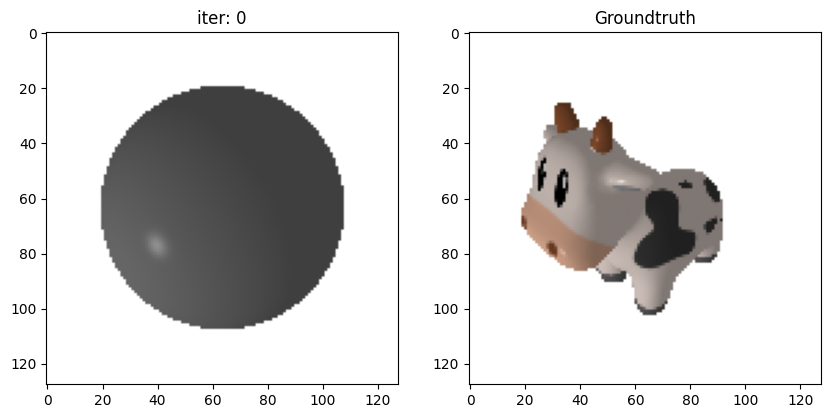

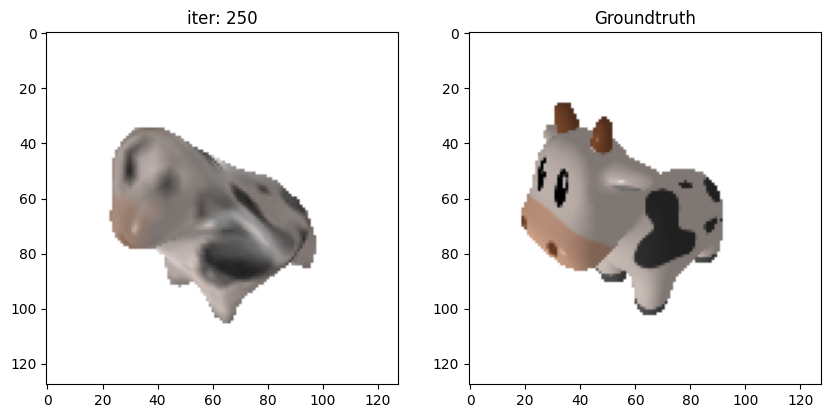

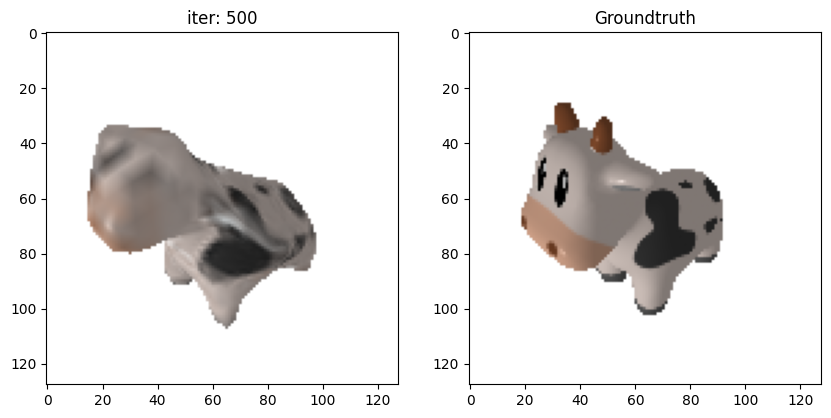

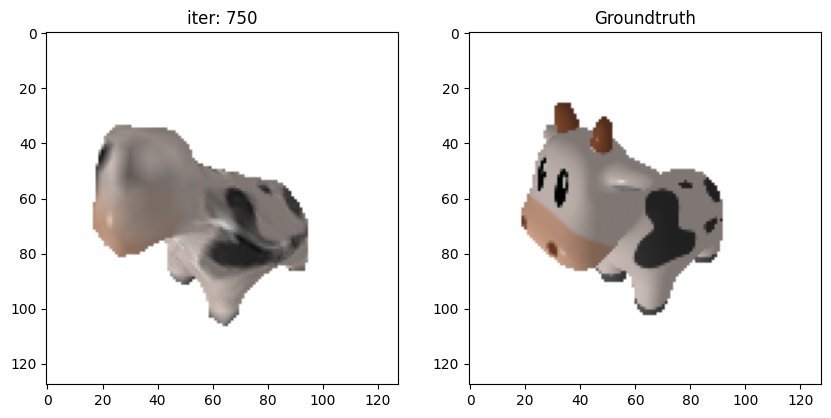

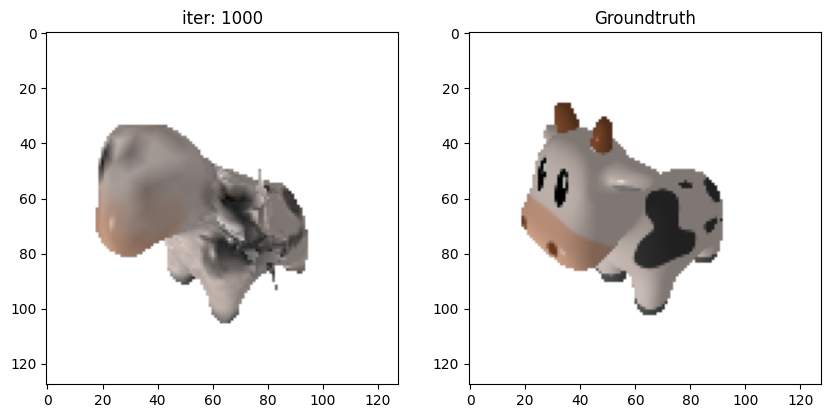

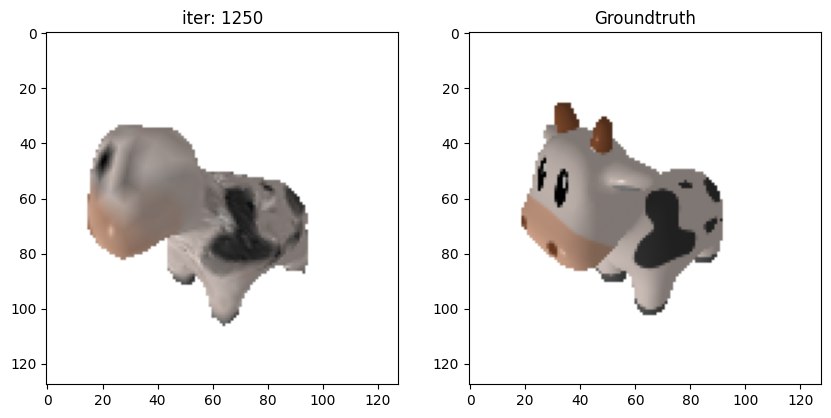

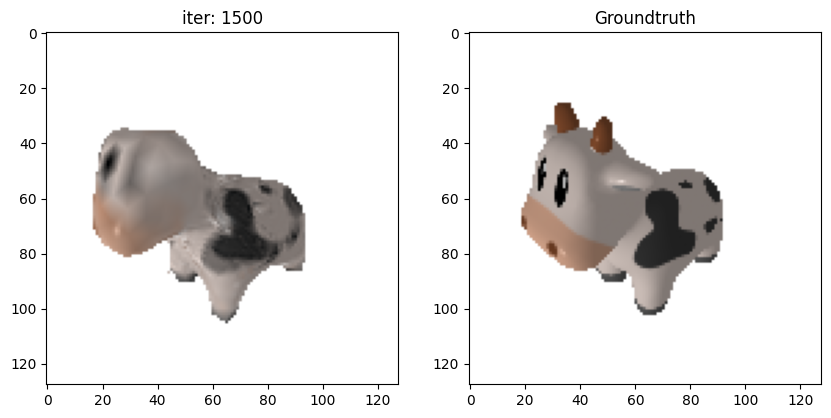

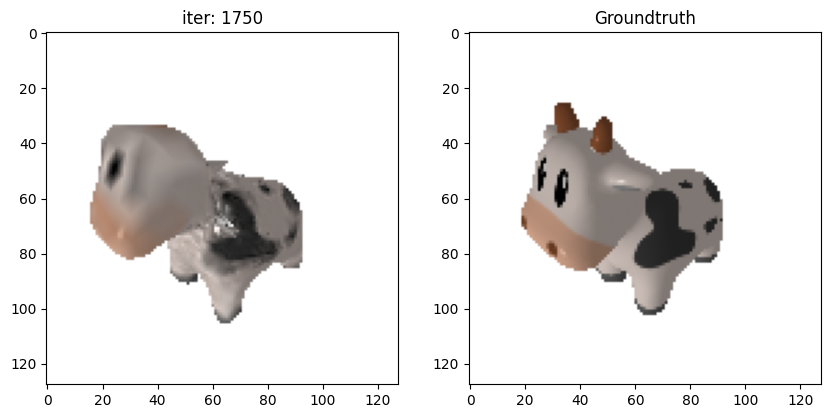

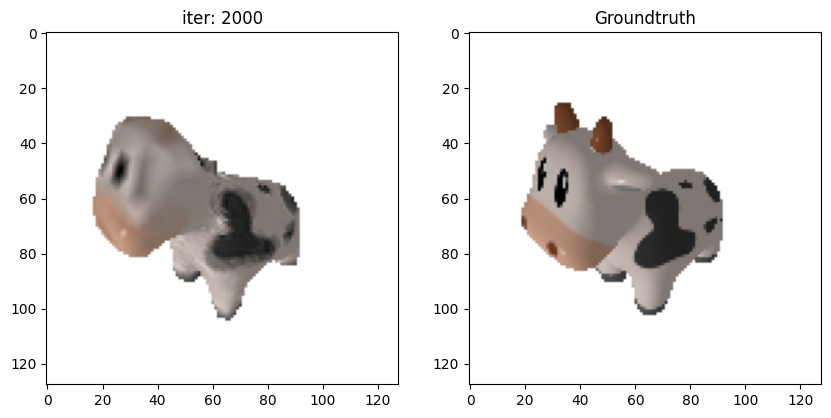

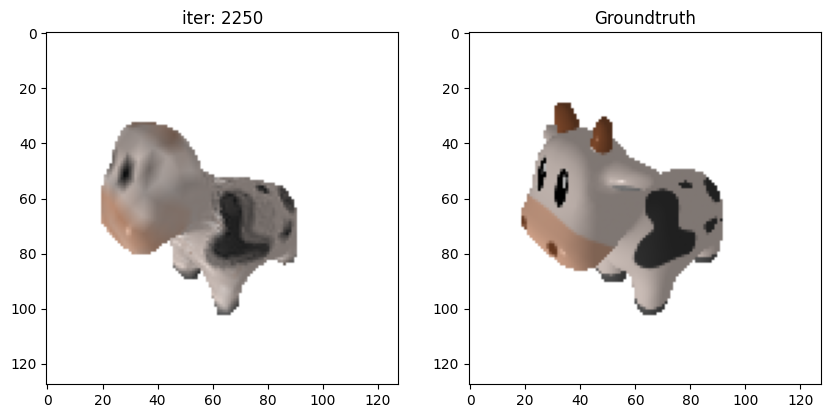

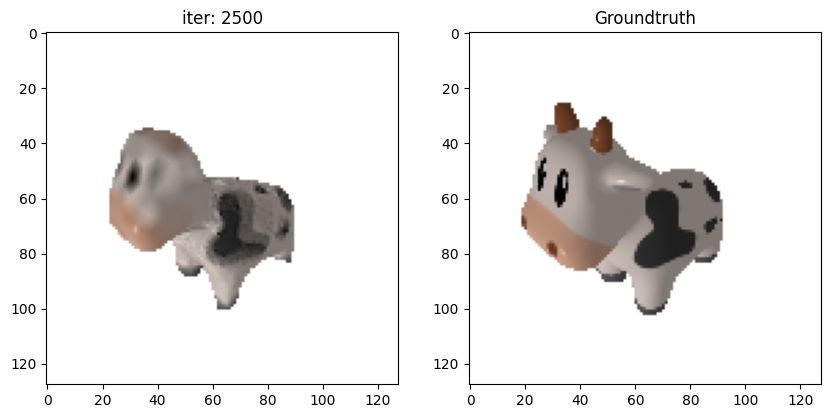

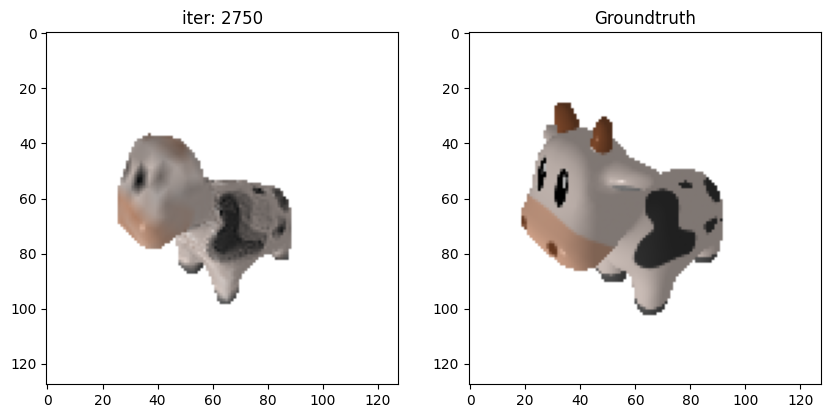

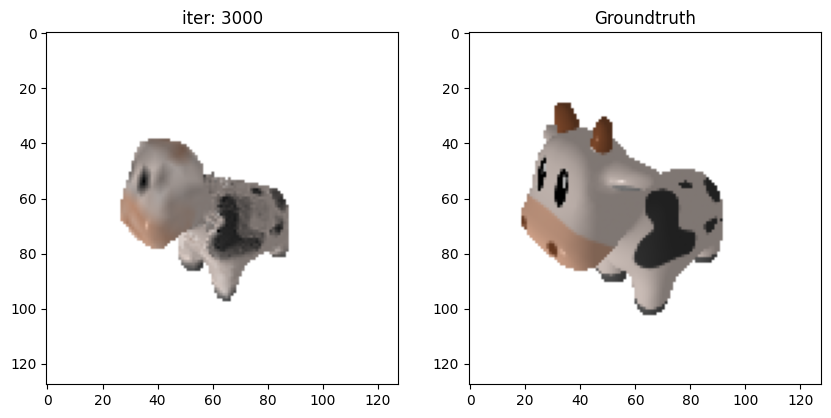

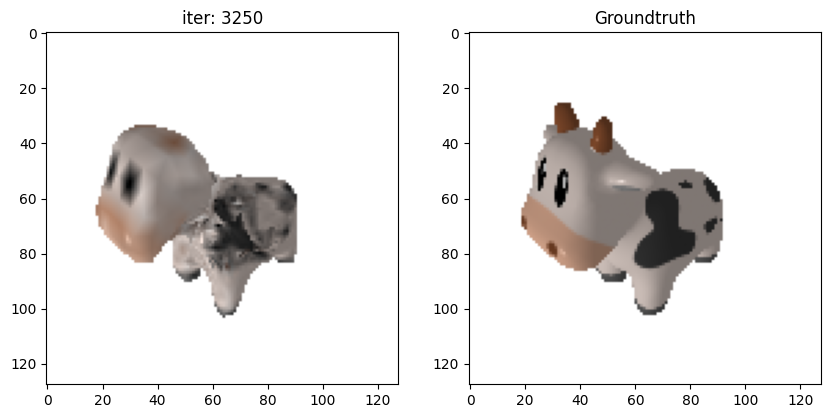

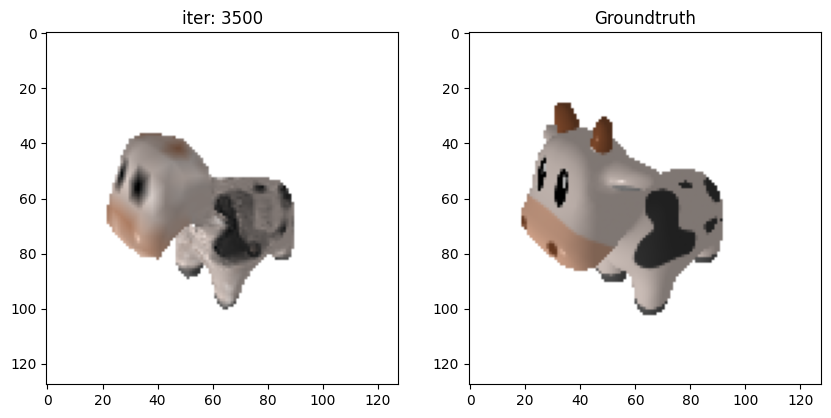

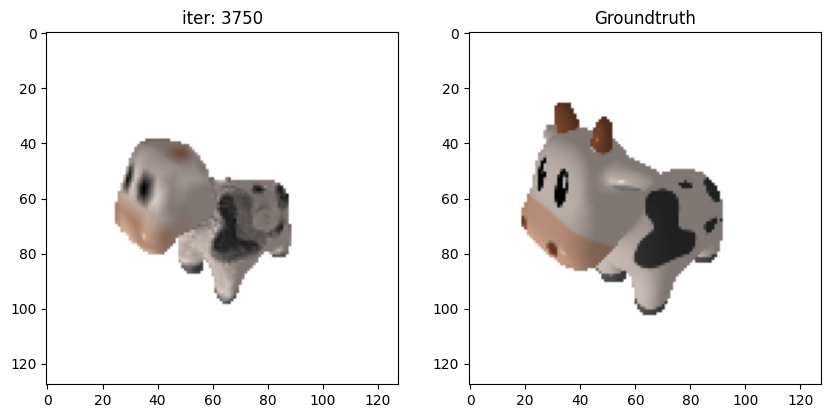

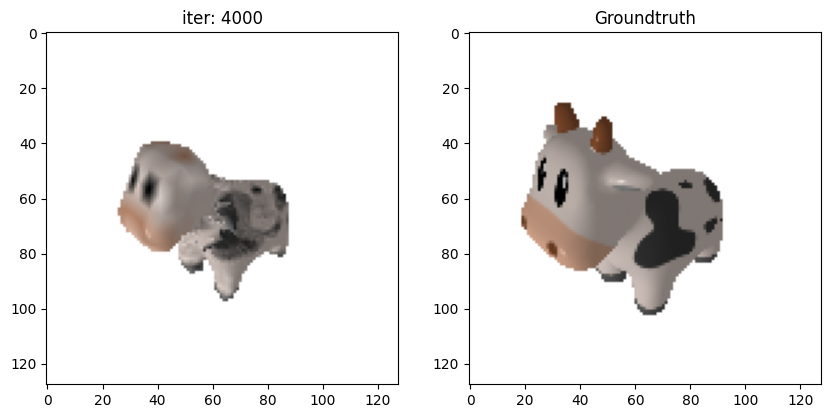

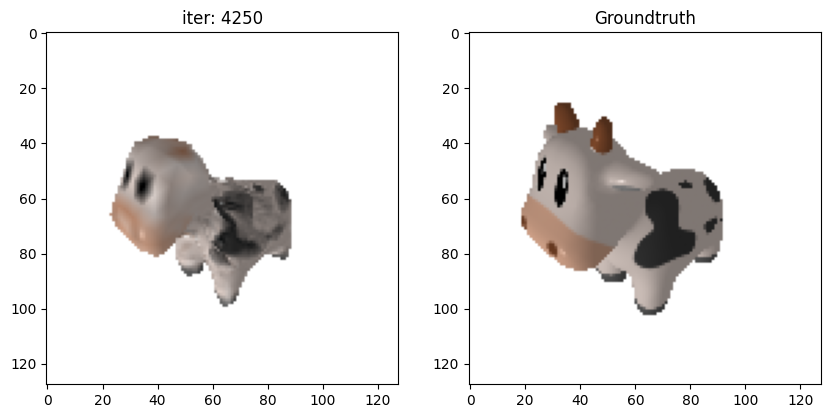

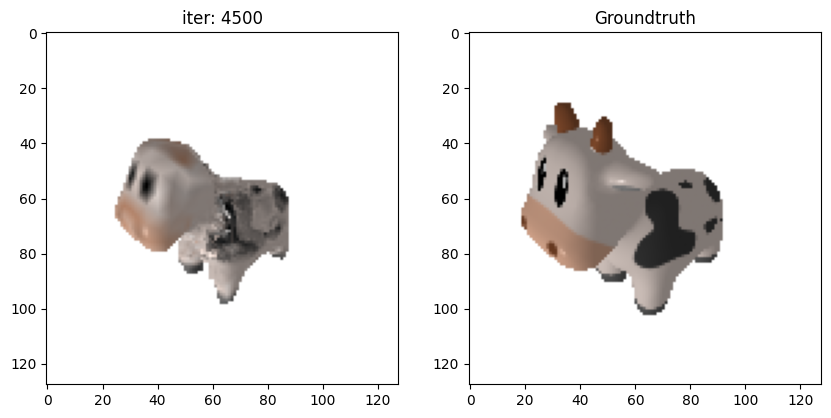

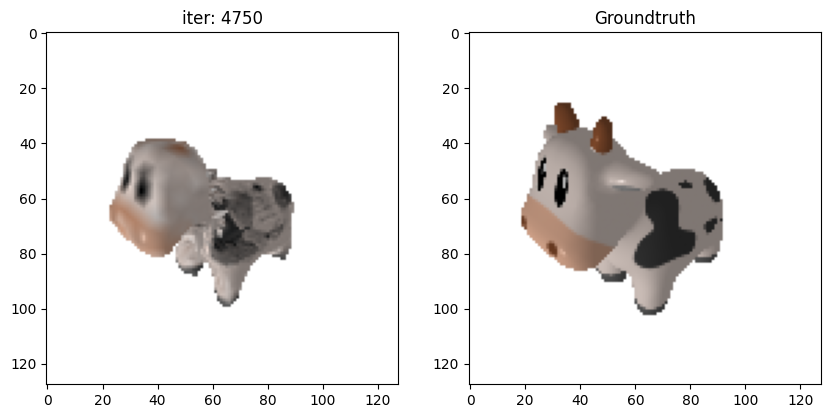

Optimization complete!


In [68]:
import imageio
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

num_iterations = 5000
plot_period = 250
log_mesh = []
log_camera = []
loop = tqdm(range(num_iterations))

# Bundle adjustment optimization loop
for i in loop:
    # Initialize the optimizer
    optimizer.zero_grad()

    # Create new mesh with predicted vertices
    pred_mesh = src_mesh.offset_verts(pred_deform_offset)

    # Add vertex colors
    pred_mesh.textures = TexturesVertex(verts_features=pred_verts_rgb)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(pred_mesh, loss)

    # Create cameras with predicted parameters
    pred_R = look_at_rotation(pred_camera_pts, device=device)
    pred_T = -torch.bmm(pred_R.transpose(1,2), pred_camera_pts[:, :, None])[:, :, 0]
    pred_cameras = FoVPerspectiveCameras(device=device, R=pred_R, T=pred_T)
    pred_images = renderer_diff(pred_mesh.extend(num_views), cameras=pred_cameras, lights=lights)


    # Sqquared L2 Silhouette loss
    loss_silhouette = ((pred_images[..., 3] - gt_silhouette[...,3]) ** 2).mean()
    loss["silhouette"] += loss_silhouette / num_views

    # Squared L2 RGB loss
    loss_rgb = ((pred_images[..., :3] - gt_rgb[..., :3]) ** 2).mean()
    loss["rgb"] += loss_rgb / num_views

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    # Print loss
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot visualizations
    if i % plot_period == 0:
        visualize_prediction(pred_mesh, title="iter: %d" % i)
        log_mesh.append(pred_mesh)
        log_camera.append(pred_cameras)

    # Step the optimizer
    sum_loss.backward()
    optimizer.step()
print("Optimization complete!")

Visualize the optimization process as a gif!

In [69]:
writer1 = imageio.get_writer("./mesh_deform.gif", mode='I', duration=0.25, loop=0)
writer2 = imageio.get_writer("./bundle_view.gif", mode='I', duration=0.25, loop=0)

for i in tqdm(range(len(log_mesh))):
    pred_mesh = log_mesh[i]
    pred_cameras = log_camera[i]
    mesh_grid, plot_camera = record_gif(pred_mesh, pred_cameras, i*plot_period)
    writer1.append_data(mesh_grid)
    writer2.append_data(plot_camera)

writer1.close()
writer2.close()

  0%|          | 0/20 [00:00<?, ?it/s]

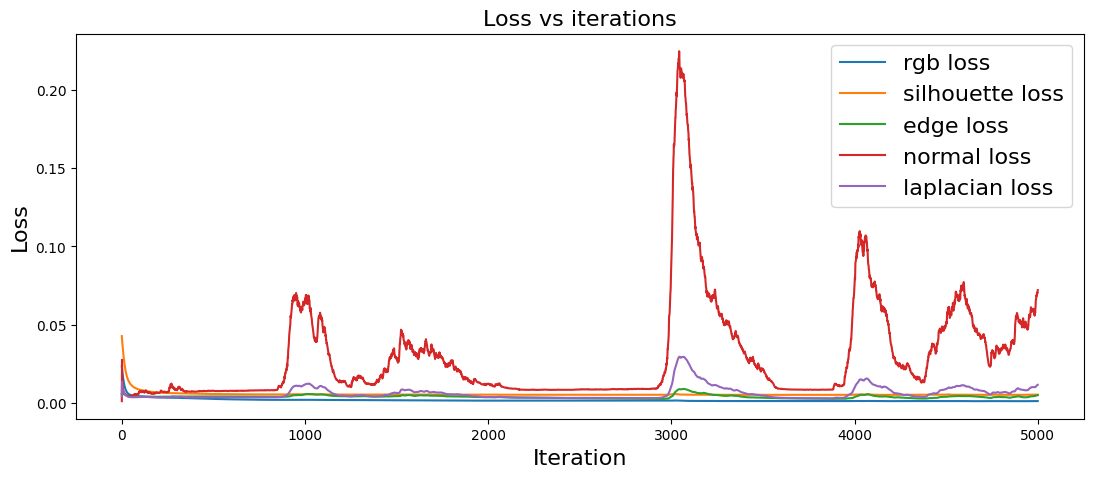

In [70]:
plot_losses(losses)

In [14]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene


fig = plot_scene({
    "Bundle Visualization": {
        "pred_mesh": pred_mesh,
        "pred_camera": pred_cameras
    }

})
fig.show()